In this notebook, we will build an abstractive based text summarizer using deep learning from the scratch in python using keras

I recommend you to go through the article over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) to cover all the concepts which is required to build our own summarizer

# Understanding the Problem Statement

Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long reviews.

We will be working on a really cool dataset. Our objective here is to generate a summary for the Amazon Fine Food reviews using the abstraction-based approach we learned about above. You can download the dataset from[ here ](https://www.kaggle.com/snap/amazon-fine-food-reviews)

It’s time to fire up our Jupyter notebooks! Let’s dive into the implementation details right away.

# Custom Attention Layer

Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation. We will go with the latter option for this article. You can download the attention layer from [here](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py) and copy it in a different file called attention.py.

Let’s import it into our environment:

# Import the Libraries

In [70]:
import numpy as np
import pandas as pd

import re
import warnings
import nltk
import datetime
import math

from IPython.display import clear_output

from pathlib import Path

from bs4 import BeautifulSoup

from nltk.corpus import stopwords

from matplotlib import pyplot
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention, Bidirectional, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [71]:
# Print iterations progress
def printProgressBar (iteration, total, suffix = 'Complete', decimals = 1, length = 20, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r> {iteration}/{total} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        clear_output(wait=True)
        print()

# Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 100,000 reviews to reduce the training time of our model. Feel free to use the entire dataset for training your model if your machine has that kind of computational power.

In [72]:
# True if in Google Colab, else if in local.
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    pj_path = "/content/drive/MyDrive/Colab Notebooks"
else:
    pj_path = "."

url = pj_path + "/dataset/Reviews.csv"
data=pd.read_csv(url, nrows=100000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Drop Duplicates and NA values

In [73]:
data.drop_duplicates(subset=['Text'],inplace=True) # Dropping duplicates
data.dropna(axis=0,inplace=True) # Dropping na

# Information about dataset

Let us look at datatypes and shape of the dataset

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [75]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


# Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [76]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [77]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
# call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

Let us look at the first five preprocessed reviews

In [79]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [80]:
# Call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [81]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [82]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

# Drop empty rows

In [83]:
data.replace('', np.nan, inplace=True)
data.replace(' ', np.nan, inplace=True)
print(data.isna().sum())
data.dropna(axis=0,inplace=True)

Id                         0
ProductId                  0
UserId                     0
ProfileName                0
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    0
Text                       0
cleaned_text               0
cleaned_summary           70
dtype: int64


# Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

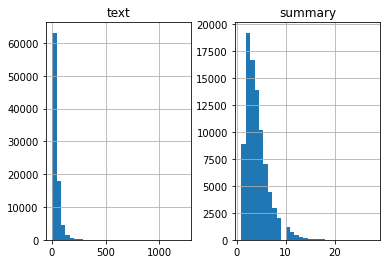

In [84]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Interesting. We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [85]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9788683772679426


We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let us fix the maximum length of review to 30

In [86]:
max_text_len=30
# max_summary_len = 8
max_summary_len = 10

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [87]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])
cleaned_score = np.array(data['Score'])

short_text=[]
short_summary=[]
short_score=[]

for i in range(len(cleaned_text)):
#    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
    if(len(cleaned_summary[i].split())<=max_summary_len-2 and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        short_score.append(cleaned_score[i])
        
df_start=pd.DataFrame({'text':short_text,'summary':short_summary,'score':short_score})
df_start=pd.get_dummies(df_start, columns = ['score'])
df_start['sentiment'] = [(lambda s: 1 if s>3 else 0)(score) for score in short_score]
df_start=pd.get_dummies(df_start, columns = ['sentiment'])

df = df_start.copy()


In [88]:
df_start.head()

,text,summary,score_1,score_2,score_3,score_4,score_5,sentiment_0,sentiment_1
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food,0,0,0,0,1,0,1
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised,1,0,0,0,0,1,0
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine,0,1,0,0,0,1,0
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy,0,0,0,0,1,0,1
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,great just as good as the expensive brands,0,0,0,0,1,0,1


Remember to add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens

**Note:** Be sure that the chosen special tokens never appear in the summary

In [89]:
df['summary'] = df_start['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [90]:
df.head()

,text,summary,score_1,score_2,score_3,score_4,score_5,sentiment_0,sentiment_1
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok,0,0,0,0,1,0,1
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok,1,0,0,0,0,1,0
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok,0,1,0,0,0,1,0
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok,0,0,0,0,1,0,1
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,sostok great just as good as the expensive brands eostok,0,0,0,0,1,0,1


We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [91]:
x_tr, x_test, y_tr, y_test =train_test_split(np.array(df['text']),np.array(df['summary']),test_size=.2,random_state=0,shuffle=True) 
x_tr, x_val, y_tr, y_val =train_test_split(x_tr,y_tr,test_size=.2,random_state=0,shuffle=True) 

# Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

## Text Tokenizer

In [92]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

### Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire text

Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word

In [93]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.24258248279136
Total Coverage of rare words: 3.5447832609381185


**Remember**:


* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)
 
*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words 

Let us define the tokenizer with top most common words for reviews.

In [94]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_test = pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [95]:
x_voc

7112

## Summary Tokenizer

In [96]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

### Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire summary

Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word

In [97]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.97415818324197
Total Coverage of rare words: 6.4096809068895535


Let us define the tokenizer with top most common words for summary.

In [98]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 
y_test_seq = y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc = y_tokenizer.num_words +1 # +1 per il padding 0!

In [99]:
y_voc

1612

Let us check whether word count of start token is equal to length of the training data

In [100]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(30188, 30188)

Here, I am deleting the rows that contain only **START** and **END** tokens

In [101]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [102]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [103]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

# Model building

Here we have all the functions used to create and use the models.

## Help functions

This cells hold all the utilities we'll need to work on a general model.

This first cell defines the functions we will use to save the model after training and load it to avoid annecessary training. 

In [104]:
import os

def save_model(model):
  path = pj_path + "/saved_models/" + model.name + "/ckpt"
  
  if not os.path.exists(os.path.dirname(path)):
    try:
      Path(path).mkdir(parents=True, exist_ok=True)
      print("Successfully created the directory %s " % path)
    except:
      print("Creation of the directory %s failed" % path)      
  model.save_weights(path)
  print("Model saved succesfully!") 

def load_model(model):
  path = pj_path + "/saved_models/" + model.name + "/ckpt"

  if os.path.exists(os.path.dirname(path)): 
    model.load_weights(path)
    print("Model loaded")
  else:
    raise IOError("Path not found")

This function will be useful after trainings. It let us plot the trainig's history (the evolution of the Accuracy and the Loss during training) given as the input.

In [105]:
def plot_history(history, model):
  print(history.history.keys())

  savefig_url = f"{pj_path}/graphs/{model.name}/"
  if not os.path.exists(os.path.dirname(savefig_url)):
    try:
      Path(savefig_url).mkdir(parents=True, exist_ok=True)
      print(f"Folder {savefig_url} created")
    except:
      raise OSError(f"Creation of the directory {savefig_url} failed")

  # Accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig1 = plt.gcf()
  plt.show()
  fig1.savefig(savefig_url+"Accuracy.png", dpi=600)
  print(f"Accuracy graph saved in {savefig_url}")

  # Loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig2 = plt.gcf()
  plt.show()
  fig2.savefig(savefig_url+"Loss.png", dpi=600)
  print(f"Loss graph saved in {savefig_url}")

## Hyperparameters

In [106]:
date_now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

EPOCHS = 50
BATCH_SIZE = 128

latent_dim    = 300
embedding_dim = 100

drop = .4
recurrent_drop = .4

is_model_lstm_trained = True
is_model_gru_trained  = True
is_model_bi_trained   = True

## Attention Layer

In [107]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


## LSTM Model


### Defining the training model

Here we're defining the LSTM model we'll use to train all the needed layers. After the training we'll separate them to get a proper encoder and a proper decoder we'll able to use to make new summmaries.

In [108]:
from tensorflow.keras import backend as K 

def get_model_lstm():
  K.clear_session()

  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,
                       dropout=drop, recurrent_dropout=recurrent_drop)

  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,
                       dropout=drop, recurrent_dropout=recurrent_drop)

  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True,
                       dropout=drop, recurrent_dropout=recurrent_drop)

  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,
                      dropout=drop, recurrent_dropout=recurrent_drop)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

  # Attention layer
  attn_layer = AttentionLayer(name='attention_layer')
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

  # Concat attention input and decoder LSTM output
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  #dense layer
  decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_concat_input)

  # Define the model 
  model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs, 
                     name = "model_lstm")

  model_lstm.summary() 

  # Compile the model using Adam as the optimizer and 
  # sparse categorical crossentropy as the loss function
  model_lstm.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

  # Let's stop the training as soon as it hits a minimum
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

  # Tensorboard will let us see the logs 
  log_dir = pj_path + "/tensorboard/"+ model_lstm.name +"/" + date_now
  tb = TensorBoard(log_dir=log_dir, histogram_freq=1)

  # We’ll train the model on a batch size of 128 and validate it on the 
  # holdout set (which is 10% of our dataset):
  if not is_model_lstm_trained:
      history=model_lstm.fit([x_tr,y_tr[:,:-1]], 
                             y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                             epochs=EPOCHS,
                             callbacks=[es,tb],
                             batch_size=BATCH_SIZE, 
                             validation_data=([x_val,y_val[:,:-1]], 
                                              y_val.reshape(y_val.shape[0],
                                                            y_val.shape[1], 
                                                            1)[:,1:]))
      plot_history(history, model_lstm)
      save_model(model_lstm)  
  else:
      load_model(model_lstm)

  # Encode the input sequence to get the feature vector
  encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

  # Decoder setup
  # Below tensors will hold the states of the previous time step
  decoder_state_input_h = Input(shape=(latent_dim,))
  decoder_state_input_c = Input(shape=(latent_dim,))
  decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

  # Get the embeddings of the decoder sequence
  dec_emb2= dec_emb_layer(decoder_inputs) 
  # To predict the next word in the sequence, set the initial states to the states from the previous time step
  decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

  #attention inference
  attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
  decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

  # A dense softmax layer to generate prob dist. over the target vocabulary
  decoder_outputs2 = decoder_dense(decoder_inf_concat) 

  # Final decoder model
  decoder_model = Model(
      [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
      [decoder_outputs2] + [state_h2, state_c2])
  
  return (encoder_model, decoder_model)

Let's create the model.

In [109]:
encoder_lstm, decoder_lstm = get_model_lstm()    

Model: "model_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      711200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_________________________________________________________________________________________

## GRU Model



### Defining the training model

Here we're defining the GRU model we'll use to train all the needed layers. After the training we'll separate them to get a proper encoder and a proper decoder we'll able to use to make new summmaries.

In [110]:
from tensorflow.keras import backend as K 

def get_model_gru():
  K.clear_session()

  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder GRU 1
  encoder_gru1 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=drop, recurrent_dropout=recurrent_drop)
  encoder_output1, state_1 = encoder_gru1(enc_emb)

  #encoder GRU 2
  encoder_gru2 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=drop, recurrent_dropout=recurrent_drop)
  encoder_output2, state_2 = encoder_gru2(encoder_output1)

  #encoder GRU 3
  encoder_gru3 = GRU(latent_dim, return_state=True, return_sequences=True,dropout=drop, recurrent_dropout=recurrent_drop)
  encoder_outputs, state = encoder_gru3(encoder_output2)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True,dropout=drop, recurrent_dropout=recurrent_drop)
  decoder_outputs, decoder_state = decoder_gru(dec_emb,initial_state=state)

  # Attention layer
  attn_layer = AttentionLayer(name='attention_layer')
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

  # Concat attention input and decoder GRU output
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  # dense layer
  decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_concat_input)

  # Define the model 
  model_gru = Model([encoder_inputs, decoder_inputs], decoder_outputs,
                    name = "model_gru")

  model_gru.summary() 

  # Compile the model using Adam as the optimizer and 
  # sparse categorical crossentropy as the loss function
  model_gru.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

  # Train the model if it's not already trained
  log_dir = pj_path + "/tensorboard/"+ model_gru.name +"/" + date_now
  tb = TensorBoard(log_dir=log_dir, histogram_freq=1)

  if not is_model_gru_trained:
      history = model_gru.fit([x_tr,y_tr[:,:-1]], 
                              y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                              epochs=EPOCHS,
                              callbacks=[es,tb],
                              batch_size=BATCH_SIZE, 
                              validation_data=([x_val,y_val[:,:-1]], 
                                              y_val.reshape(y_val.shape[0],
                                                            y_val.shape[1], 
                                                            1)[:,1:]))
      plot_history(history, model_gru)
      save_model(model_gru)  
  else:
      load_model(model_gru)
      
  # Encode the input sequence to get the feature vector
  encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state])

  # Decoder setup
  # Below tensors will hold the states of the previous time step
  decoder_state_input = Input(shape=(latent_dim,))
  decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

  # Get the embeddings of the decoder sequence
  dec_emb2= dec_emb_layer(decoder_inputs) 
  # To predict the next word in the sequence, set the initial states to the states from the previous time step
  decoder_outputs2, state_2 = decoder_gru(dec_emb2, initial_state=[decoder_state_input])

  #attention inference
  attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
  decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

  # A dense softmax layer to generate prob dist. over the target vocabulary
  decoder_outputs2 = decoder_dense(decoder_inf_concat) 

  # Final decoder model
  decoder_model = Model(
      [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input],
      [decoder_outputs2] + [state_2])
  
  return (encoder_model, decoder_model)

Let's create the model.

In [111]:
encoder_gru, decoder_gru = get_model_gru()

Model: "model_gru"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      711200      input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       [(None, 30, 300), (N 361800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________

## Bidirectional GRU Model

In [112]:
from tensorflow.keras import backend as K 

def get_model_bi():
  K.clear_session()

  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder bi_gru 1
  encoder_gru1 = Bidirectional(GRU(latent_dim,return_sequences=True,return_state=True,dropout=drop, recurrent_dropout=recurrent_drop),
                               merge_mode="ave")
  encoder_output1, state_fw_1, state_bw_1 = encoder_gru1(enc_emb)

  #encoder bi_gru 2
  encoder_gru2 = Bidirectional(GRU(latent_dim,return_sequences=True,return_state=True,dropout=drop, recurrent_dropout=recurrent_drop),
                              merge_mode="ave")
  encoder_output2, state_fw_2, state_bw_2 = encoder_gru2(encoder_output1)

  #encoder bi_gru 3
  encoder_gru3 = Bidirectional(GRU(latent_dim, return_state=True, return_sequences=True,dropout=drop, recurrent_dropout=recurrent_drop),
                              merge_mode="ave")
  encoder_outputs, state_fw_3, state_bw_3 = encoder_gru3(encoder_output2)

  # Decoder
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  # decoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True,dropout=0.4),
  #                             merge_mode="ave")
  decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True,dropout=drop, recurrent_dropout=recurrent_drop)
  # decoder_outputs, decoder_fw_state, decoder_bw_state = decoder_gru(dec_emb, initial_state=[state_fw_3, state_bw_3])
  decoder_outputs, decoder_state = decoder_gru(dec_emb, initial_state=state_fw_3)

  # Attention layer
  attn_layer = AttentionLayer(name='attention_layer')
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

  # Concat attention input and decoder bi_gru output
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  # dense layer
  decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_concat_input)

  # Define the model 
  model_bi = Model([encoder_inputs, decoder_inputs], decoder_outputs,
                  name = "model_bi")

  model_bi.summary() 

  model_bi.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  # Callbacks
  log_dir = pj_path + "/tensorboard/"+ model_bi.name + "/" + date_now

  early_stopping_callback   = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
  tensorboard_callback      = TensorBoard(log_dir=log_dir, histogram_freq=1)
  
  callbacks = [early_stopping_callback,
               tensorboard_callback]
               # model_checkpoint_callback]

  
  if not is_model_bi_trained:
    history = model_bi.fit([x_tr,y_tr[:,:-1]], 
                            y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                            epochs=EPOCHS,
                            callbacks=callbacks,
                            batch_size=BATCH_SIZE, 
                            validation_data=([x_val,y_val[:,:-1]], 
                                              y_val.reshape(y_val.shape[0],
                                                            y_val.shape[1], 
                                                            1)[:,1:]))
    plot_history(history, model_bi)
    save_model(model_bi)
  else:
    load_model(model_bi)

  # Encode the input sequence to get the feature vector
  encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_fw_3, state_bw_3])

  # Decoder setup
  # Below tensors will hold the states of the previous time step
  decoder_state_input_fw = Input(shape=(latent_dim,))
  decoder_state_input_bw = Input(shape=(latent_dim,))
  decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

  # Get the embeddings of the decoder sequence
  dec_emb2 =  dec_emb_layer(decoder_inputs) 
  # To predict the next word in the sequence, set the initial states to the states from the previous time step
  # decoder_outputs2, state_fw_2, state_bw_2 = decoder_gru(dec_emb2, initial_state=[decoder_state_input_fw, decoder_state_input_bw])
  decoder_outputs2, state_fw_2 = decoder_gru(dec_emb2, initial_state=decoder_state_input_fw)

  #attention inference
  attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
  decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

  # A dense softmax layer to generate prob dist. over the target vocabulary
  decoder_outputs2 = decoder_dense(decoder_inf_concat) 

  # Final decoder model
  decoder_model = Model(
      [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_fw],
      [decoder_outputs2] + [state_fw_2])
  
  return (encoder_model, decoder_model)

Let's create the model.

In [113]:
encoder_bi, decoder_bi = get_model_bi()

Model: "model_bi"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      711200      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 30, 300), (N 723600      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
___________________________________________________________________________________________

# Inference

First, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [114]:
target_word_index = y_tokenizer.word_index
reverse_target_word_index = y_tokenizer.index_word

source_word_index = x_tokenizer.word_index
reverse_source_word_index = x_tokenizer.index_word

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [115]:
def decode_sequence(input_seq,
                    model_type = "LSTM", 
                    encoder_model=encoder_lstm, 
                    decoder_model=decoder_lstm):

    if model_type in ["LSTM", "Bi"]:
      e_out, h, c = encoder_model.predict(input_seq)
    else:
      e_out, h = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        
        if model_type in ["LSTM"]:
          output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, h, c])
        else:
          output_tokens, h = decoder_model.predict([target_seq] + [e_out, h])
          
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if (sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [116]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [117]:
for i in range(0,25):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))

    input_seq = x_test[i].reshape(1,max_text_len)
    print("Predicted summary - LSTM model:\n\t", 
          decode_sequence(input_seq,
                          "LSTM",
                          encoder_lstm,
                          decoder_lstm))
    
    print("Predicted summary - GRU  model:\n\t", 
          decode_sequence(input_seq,
                          "GRU",
                          encoder_gru,
                          decoder_gru))
    
    print("Predicted summary - Bi   model:\n\t", 
          decode_sequence(input_seq,
                          "Bi",
                          encoder_bi,
                          decoder_bi))

    print("\n")

Review: great healthy chew old beagle loves taste sure beats arm 
Original summary: yummy 
Predicted summary - LSTM model:
	  my loves these
Predicted summary - GRU  model:
	  my dog loves these
Predicted summary - Bi   model:
	  great product


Review: thank goodness carbonated drink tasty without additives taste like cherry drinks slightly lighter flavoring although less half volume normal wonder things good comes small size least recycled 
Original summary: it is tasty 
Predicted summary - LSTM model:
	  delicious
Predicted summary - GRU  model:
	  not my favorite flavor
Predicted summary - Bi   model:
	  great product


Review: extra bold coffee one favorites extra bold could compared bold coffee regular coffee brewer 
Original summary: great coffee for keurig brewer 
Predicted summary - LSTM model:
	  great coffee
Predicted summary - GRU  model:
	  great coffee
Predicted summary - Bi   model:
	  great coffee


Review: like flavored coffee taste like coffee may could taste coffee t

In [118]:
verbose = True
predicted_list = []
review_list = []
original_summary_list = []

# dimension = x_test.shape[0]
dimension = 1

for i in range(dimension):
    review_list.append(seq2text(x_test[i]))
    original_summary_list.append(seq2summary(y_test[i]))
    predicted_list.append(decode_sequence(x_test[i].reshape(1,max_text_len)))
    if i%1==0 and verbose:
        clear_output(wait=True)
        print("> {0} / {1} \t {2:.2f}%".format(i+1, dimension, ((i+1)/dimension)*100))

> 1 / 1 	 100.00%


In [119]:
pred_dict = {'review': review_list, 'original_summary':original_summary_list, 'predicted_list':predicted_list}
pred_df = pd.DataFrame(data=pred_dict)
pred_df.to_csv(pj_path + '/dataset/predicted_reviews.csv', index=False)

In [120]:
pred_df.head()

,review,original_summary,predicted_list
0,great healthy chew old beagle loves taste sure beats arm,yummy,my loves these


In [121]:
from nltk.translate.bleu_score import sentence_bleu

tot_score = 0

for ref, cand in zip(review_list, predicted_list):
    score = sentence_bleu(ref, cand)
    tot_score = tot_score + score
mean_score = tot_score/(len(review_list))

In [122]:
print(mean_score)

0.9036020036098448


# Evaluation of the Summary Model
Adesso bisogna risolvere il problema della valutazione del modello della summary che abbiamo precedentemente addestrato. Per la valutazione possiamo utilizzare tre possibili approcci:
* rating prediction;
* sentiment analisys;
* bleau score.
In questa sezione andremo prima a creare quattro diversi modelli per poi valutarli e scegliere il migliore per effettuare la valutazione del summary model.

In [123]:
df_start.head()

,text,summary,score_1,score_2,score_3,score_4,score_5,sentiment_0,sentiment_1
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food,0,0,0,0,1,0,1
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised,1,0,0,0,0,1,0
2,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine,0,1,0,0,0,1,0
3,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy,0,0,0,0,1,0,1
4,saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...,great just as good as the expensive brands,0,0,0,0,1,0,1


## Split del Dataset
Considerando il dataset composto dalle seguenti colonne:
* text: contiene il testo da dare in input al summary model per generare le predicted summaries;
* summary: le summaries che veranno usate come label;
* score: gli scores associati da ogni utente alla recensione;
* sentiment: il valore di sentiment da utilizzare come label dedotto utilizzando la seguente regola:
   * se lo score del rating è > 3 allora sentiment uguale a 1;
   * se lo score del rating è <= 3 allora sentiment uguale a 0.

Ora eseguiamo lo split del dataset associando le lettere x, y, z e k nel seguente modo:
* x = colonna _summary_;
* y = le colonne _score_;
* z = la colonna _text_;
* k = le colonne _sentiment_.

In [124]:
y_classes=['score_1','score_2','score_3','score_4','score_5',]
y = df_start[y_classes].values
k_classes=['sentiment_0','sentiment_1']
K = df_start[k_classes].values

X = df_start['summary']
Z = df_start['text']

In [125]:
# x = the original summaries
# y = the scores
# z = the texts
# k = sentiment

x_tr_sent, x_test_sent, y_tr_sent, y_test_sent, _ , z_test, k_tr_sent, k_test_sent = train_test_split(np.array(X),np.array(y),np.array(Z),np.array(K),test_size=.2,random_state=0,shuffle=True)

x_tr_sent, x_val_sent, y_tr_sent, y_val_sent, k_tr_sent, k_val_sent = train_test_split(x_tr_sent,y_tr_sent,k_tr_sent,test_size=0.2,random_state=0,shuffle=True)

## Tokenizer
Come è stato fatto per il summary model è molto importante creare un tokenizzatore per convertire le stringhe in numeri da poter sottoporre alle reti neurali.

### Summary Tokenizer
Per la tokenizzazione dei summary possiamo utilizzare lo stesso Tokenizzatore creato in precedenza per il modello della summary.

In [126]:
#convert text sequences into integer sequences
x_tr_seq = y_tokenizer.texts_to_sequences(x_tr_sent) 
x_val_seq = y_tokenizer.texts_to_sequences(x_val_sent)
x_test_seq = y_tokenizer.texts_to_sequences(x_test_sent)

#padding zero upto maximum length
x_tr_sent = pad_sequences(x_tr_seq,  maxlen=max_summary_len, padding='post')
x_val_sent = pad_sequences(x_val_seq, maxlen=max_summary_len, padding='post')
x_test_sent = pad_sequences(x_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc_sent = y_tokenizer.num_words + 1

### Text Tokenizer
Per il text tokenizer dobbiamo utilizzare quello creato in precedenza per il modello della summary prediction così da poter poi passare i tokens al modello della summary.

In [127]:
#convert text sequences into integer sequences
z_test_seq = x_tokenizer.texts_to_sequences(z_test)

#padding zero upto maximum length
z_test = pad_sequences(z_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
z_voc   =  x_tokenizer.num_words + 1

In [128]:
z_voc

7112

## Creazione e Addestramento dei modelli

### Hyperparameters

In [129]:
is_model_rating_lstm_trained = True
is_model_sentiment_lstm_trained = True
is_model_sentiment_gru_trained = True

### Help Function

In [130]:
def get_test_results(label, predictions, model:str, file_name:str):
    path_results = f"{pj_path}/evaluation_results/{model}/"
    w = False

    if not os.path.exists(os.path.dirname(path_results)):
        try:
            Path(path_results).mkdir(parents=True, exist_ok=True)
            print(f"Folder {path_results} created")
        except:
            print(f"Creation of the directory {path_results} failed")
        else:
            w = True
    else:
      w = True

    # Counts of unique
    unique, counts = np.unique(label, return_counts=True)
    dict_real = dict(zip(unique, counts))
    unique, counts = np.unique(predictions, return_counts=True)
    dict_pred = dict(zip(unique, counts))

    # Confusion Matrix
    cnf_matrix = confusion_matrix(label, predictions)

    # Classification Report
    class_rep = classification_report(label, predictions)

    results_str = f"Valori reali: {dict_real}\nValori predetti: {dict_pred}\n\nConfusion Matrix:\n{cnf_matrix}\n\nClassification Report:\n{class_rep}"

    if w:
        writable_file = open(path_results+f"{file_name}.txt",'w')
        writable_file.write(results_str)
        writable_file.close()
    
    print(results_str)

### Modello per il Rating
Generiamo un modello che sia in grado di predire un valore di rating intero in un intervallo tra 1 e 5. L'idea alla base è che una frase e la summary della stessa frase generano lo stesso valore di rating.

In [131]:
def get_rating_model_lstm(h_drop=0, h_rec_drop=0):
    rating_model = Sequential([
        Embedding(x_voc_sent, 64, trainable=True, mask_zero=True),
        Bidirectional(LSTM(64,  return_sequences=True, dropout=h_drop, recurrent_dropout=h_rec_drop)),
        Bidirectional(LSTM(32, dropout=h_drop, recurrent_dropout=h_rec_drop)),
        Dense(64, activation='elu'),
        Dropout(0.5),
        Dense(5, activation='sigmoid')],
        name="rating_LSTM_evaluation_model")

    tb_dir = pj_path + "/tensorboard/"+ rating_model.name +"/" + date_now

    tb = TensorBoard(log_dir=tb_dir, histogram_freq=1)
    earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

    rating_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    rating_model.summary()

    if not is_model_rating_lstm_trained:
        history = rating_model.fit(x_tr_sent[:,:],
                                   y_tr_sent, 
                                   batch_size=128, 
                                   validation_data=(x_val_sent[:,:], y_val_sent), 
                                   epochs=EPOCHS,
                                   callbacks=[earlystop, tb])
        plot_history(history, rating_model)
        save_model(rating_model)
    else:
        load_model(rating_model)

    return rating_model

In [132]:
rating_model = get_rating_model_lstm()

Model: "rating_LSTM_evaluation_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          103168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 214,917
Trainable params: 214,917
Non-trainable params: 0
________________________________

Infine eseguiamo il modello sul dataset di test.

In [133]:
x_test_sent_resh = x_test_sent
for i in range(x_test_sent.shape[0]):
    x_test_sent_resh[i].reshape(1,max_summary_len)

In [134]:
predictions = rating_model.predict(x_test_sent_resh[:,:], verbose=1)

295/295 [==============================] - 35s 106ms/step


In [135]:
test_scores = y_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)

Tramite la confusion matrix possiamo calcolarci alcuni diversi indici:

* Accuracy $\frac{TP+TN}{TP+FP+TN+FN}$ che rappresenta la percentuale di classificazioni corrette;
* Precision $\frac{TP}{TP+FP}$ che rappresenta la percentuale di classificazioni positive che sono corrette;
* Recall $\frac{TP}{TP+FN}$ che rappresenta la percentuale di elementi positivi che sono stati classificati come positivi
* F1 score $2\cdot\frac{Precision \cdot Recall}{Precision + Recall}$ che rappresenta la media pesata della precisione e della recall.


In [136]:
get_test_results(test_scores, test_predicted_scores, rating_model.name, "test")

Valori reali: {0: 806, 1: 468, 2: 591, 3: 1199, 4: 6370}
Valori predetti: {0: 880, 1: 99, 2: 463, 3: 202, 4: 7790}

Confusion Matrix:
[[ 458   32   56    3  257]
 [ 177   40   80    3  168]
 [  99   18  168   41  265]
 [  44    4   90   94  967]
 [ 102    5   69   61 6133]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       806
           1       0.40      0.09      0.14       468
           2       0.36      0.28      0.32       591
           3       0.47      0.08      0.13      1199
           4       0.79      0.96      0.87      6370

    accuracy                           0.73      9434
   macro avg       0.51      0.40      0.40      9434
weighted avg       0.68      0.73      0.68      9434



Nonostante si possa osservare un buon livello di accuracy in realtà questo modello non è adatto per valutare le summary generate per due motivi principali:
* il linguaggio naturale è difficile da interpretare;
* pre predire dei ratings è meglio utilizzare altri approcci che siano in gradi di tenere conto anche del rating medio di un singolo utente (cosa che in questo caso non si può fare per via della mancanza dei dati necessari).

### Modello per il Sentiment (LSTM)
Un altro modello che possiamo utilizzare per valutare il modello per la generazione dei summaries è un modello in grado di effettuare il sentiment analisys. Tale modello è in grado di estrarre il sentiment dell'utente che ha scritto il text.

La valutazione si basa sull'idea che una summary genera lo stesso sentiment del testo da cui viene generata.

In [137]:
def get_sentiment_model_lstm(h_drop=0, h_rec_drop=0):
    sentiment_model = Sequential([
        Embedding(x_voc_sent, 64, trainable=True, mask_zero=True),
        Bidirectional(LSTM(64,  return_sequences=True, dropout=h_drop, recurrent_dropout=h_rec_drop)),
        Bidirectional(LSTM(32, dropout=h_drop, recurrent_dropout=h_rec_drop)),
        Dense(64, activation='elu'),
        Dropout(0.5),
        Dense(2)
        ], name="sentiment_LSTM_evaluation_model")

    tb_dir = pj_path + "/tensorboard/"+ sentiment_model.name +"/" + date_now

    tb = TensorBoard(log_dir=tb_dir, histogram_freq=1)
    earlystop = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1,patience=2)

    sentiment_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    sentiment_model.summary()

    if not is_model_sentiment_lstm_trained:
        # Train del modello. Il train sfrutta come labels le colonne _sentiment_ del dataset create nel seguente modo:
        # * se lo score del rating è > 3 allora sentiment uguale a 1 (positivo);
        # * se lo score del rating è <= 3 allora sentiment uguale a 0 (negativo).
        history=sentiment_model.fit(
            x_tr_sent[:,:],
            k_tr_sent,
            batch_size=128,
            validation_data=(x_val_sent[:,:], k_val_sent),
            epochs=EPOCHS,
            callbacks=[earlystop, tb])

        plot_history(history, sentiment_model)
        save_model(sentiment_model)
    else:
        load_model(sentiment_model)

    return sentiment_model

In [138]:
sentiment_model = get_sentiment_model_lstm()

Model: "sentiment_LSTM_evaluation_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          103168    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 214,722
Trainable params: 214,722
Non-trainable params: 0
_____________________________

Infine eseguiamo il modello sul dataset di test.

In [139]:
predictions = sentiment_model.predict(x_test_sent_resh[:,:], verbose=1)

295/295 [==============================] - 7s 10ms/step


Tramite la confusion matrix possiamo calcolarci alcuni diversi indici:

* Accuracy $\frac{TP+TN}{TP+FP+TN+FN}$ che rappresenta la percentuale di classificazioni corrette;
* Precision $\frac{TP}{TP+FP}$ che rappresenta la percentuale di classificazioni positive che sono corrette;
* Recall $\frac{TP}{TP+FN}$ che rappresenta la percentuale di elementi positivi che sono stati classificati come positivi
* F1 score $2\cdot\frac{Precision \cdot Recall}{Precision + Recall}$ che rappresenta la media pesata della precisione e della recall.


In [140]:
test_scores = k_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)

get_test_results(test_scores, test_predicted_scores, sentiment_model.name, "test")

Valori reali: {0: 1865, 1: 7569}
Valori predetti: {0: 1201, 1: 8233}

Confusion Matrix:
[[ 982  883]
 [ 219 7350]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.53      0.64      1865
           1       0.89      0.97      0.93      7569

    accuracy                           0.88      9434
   macro avg       0.86      0.75      0.79      9434
weighted avg       0.88      0.88      0.87      9434



Rispetto al precedente modello di predizione del rating si può osservare un aumento dell'accuracy. In particolare il modello sembrerebbe mostrare dei buoni risultati se si considera il fatto che il dataset è fortemente squilibrato rispetto ai valori di label e nonostante ciò riesce a generalizzare abbastanza bene.

### Modello per il Sentiment (GRU)
Il modello qui sotto riportato è una variante del modello per il calcolo del sentiment appena visto. La differenza si trova nei layer bidirezionali che sfruttano layer GRU invece di quelli LSTM.

La valutazione si basa sull'idea che una summary genera lo stesso sentiment del testo da cui viene generata.

In [141]:
def get_sentiment_model_gru(h_drop=0, h_rec_drop=0):
    sentiment_gru_model = Sequential([
        Embedding(x_voc_sent, 64, trainable=True, mask_zero=True),
        Bidirectional(GRU(64, return_sequences=True, dropout=h_drop, recurrent_dropout=h_rec_drop)),
        Bidirectional(GRU(32, dropout=h_drop, recurrent_dropout=h_rec_drop)),
        Dense(64, activation='elu'),
        Dropout(0.5),
        Dense(2)
        ], name="sentiment_GRU_evaluation_model")

    tb_dir = pj_path + "/tensorboard/"+ sentiment_gru_model.name +"/" + date_now

    tb = TensorBoard(log_dir=tb_dir, histogram_freq=1)
    earlystop = EarlyStopping(monitor = 'val_loss', mode='min', verbose=1, patience=2)

    sentiment_gru_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    sentiment_gru_model.summary()
    
    if not is_model_sentiment_gru_trained:
        # Train del modello. Il train sfrutta come labels le colonne _sentiment_ del dataset create nel seguente modo:
        # * se lo score del rating è > 3 allora sentiment uguale a 1 (positivo);
        # * se lo score del rating è <= 3 allora sentiment uguale a 0 (negativo).
        history = sentiment_gru_model.fit(
            x_tr_sent[:,:],
            k_tr_sent,
            batch_size=128,
            validation_data=(x_val_sent[:,:], k_val_sent),
            epochs=EPOCHS,
            callbacks=[earlystop, tb])

        plot_history(history, sentiment_gru_model)
        save_model(sentiment_gru_model)
    else:
        load_model(sentiment_gru_model)

    return sentiment_gru_model

In [142]:
sentiment_gru_model = get_sentiment_model_gru()

Model: "sentiment_GRU_evaluation_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          103168    
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 128)         49920     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 188,482
Trainable params: 188,482
Non-trainable params: 0
______________________________

Infine eseguiamo il modello sul dataset di test.

In [143]:
predictions = sentiment_gru_model.predict(x_test_sent_resh[:,:], verbose=1)

295/295 [==============================] - 7s 10ms/step


Tramite la confusion matrix possiamo calcolarci alcuni diversi indici:

* Accuracy $\frac{TP+TN}{TP+FP+TN+FN}$ che rappresenta la percentuale di classificazioni corrette;
* Precision $\frac{TP}{TP+FP}$ che rappresenta la percentuale di classificazioni positive che sono corrette;
* Recall $\frac{TP}{TP+FN}$ che rappresenta la percentuale di elementi positivi che sono stati classificati come positivi
* F1 score $2\cdot\frac{Precision \cdot Recall}{Precision + Recall}$ che rappresenta la media pesata della precisione e della recall.


In [144]:
test_scores = k_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)

get_test_results(test_scores, test_predicted_scores, sentiment_gru_model.name, "test")

Valori reali: {0: 1865, 1: 7569}
Valori predetti: {0: 1319, 1: 8115}

Confusion Matrix:
[[1030  835]
 [ 289 7280]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.55      0.65      1865
           1       0.90      0.96      0.93      7569

    accuracy                           0.88      9434
   macro avg       0.84      0.76      0.79      9434
weighted avg       0.87      0.88      0.87      9434



In confronto al precedente modello (LSTM) possiamo vedere dei valori di accuracy nettamente peggiori. Questo modello non verrà utilizzato per la valutazione del summary model.

# Valutazione dei modelli del summary generator
Sulla base dei modelli di valutazione che abbiamo creato nella sezione precedente possiamo procedere con la valutazione del summary model.

I risultati precedenti indicano che il modello di sentiment con le migliori prestazioni è il modello con i layers bidirezionali LSTM. Per motivi didattici in questa sezione la RNN verrà comunque valutata con tutti i modelli creati nella sezione precedente.

Come già spiegato in precedenza, la valutazione del modello di summary si basa sull'idea che la summary e il suo testo originale producono lo stesso score di rating o di sentiment.

Per prima cosa procediamo con il predire le summaries dal testo originale con le tre reti di summary generation create prima.

In [145]:
verbose = True

predicted_lstm_list = [] # lista dei summaries predetti tramite il modello LSTM summary model
predicted_gru_list = [] # lista dei summaries predetti tramite il modello GRU summary model
predicted_bi_list = [] # lista dei summaries predetti tramite il modello Bidirectional summary model

dimension = z_test.shape[0]

for i in range(dimension):
    # decode using the LSTM model
    predicted_lstm_list.append(decode_sequence(z_test[i].reshape(1,max_text_len), "LSTM", encoder_lstm, decoder_lstm))
    # decode using the GRU model
    predicted_gru_list.append(decode_sequence(z_test[i].reshape(1,max_text_len), "GRU", encoder_gru, decoder_gru))
    # decode using the Bidirectional model
    predicted_bi_list.append(decode_sequence(z_test[i].reshape(1,max_text_len), "Bi", encoder_bi, decoder_bi))

    if i%1==0 and verbose:
        clear_output(wait=True)
        print("> {0} / {1} \t {2:.2f}%".format(i+1, dimension, ((i+1)/dimension)*100))


> 1051 / 9434 	 11.14%


KeyboardInterrupt: ignored

Ora che abbiamo le summaries predette dal modello è importante codificarle tramite un tokenizzatore. Di seguito useremo `x_tokenizer_sent` in quanto è il tokenizzatore utilizzato per codificare le summaries per la sentiment analisys.

In [ ]:
# possiamo utilizzare y_tokenizer in quanto quello che abbiamo generato tramite la predizione è un summary e y_tokenizer si occupa di tokenizzare proprio i summary.
# LSTM predictions reshape
predicted_lstm_list_seq = y_tokenizer.texts_to_sequences(predicted_lstm_list)
predicted_lstm_list = pad_sequences(predicted_lstm_list_seq, maxlen=max_summary_len, padding='post')
predicted_lstm_list_resh = predicted_lstm_list
for i in range(predicted_lstm_list.shape[0]):
    predicted_lstm_list_resh[i].reshape(1,max_summary_len)

# GRU predictions reshape
predicted_gru_list_seq = y_tokenizer.texts_to_sequences(predicted_gru_list)
predicted_gru_list = pad_sequences(predicted_gru_list_seq, maxlen=max_summary_len, padding='post')
predicted_gru_list_resh = predicted_gru_list
for i in range(predicted_gru_list.shape[0]):
    predicted_gru_list_resh[i].reshape(1,max_summary_len)

# Bidirectional predictions reshape
predicted_bi_list_seq = y_tokenizer.texts_to_sequences(predicted_bi_list)
predicted_bi_list = pad_sequences(predicted_bi_list_seq, maxlen=max_summary_len, padding='post')
predicted_bi_list_resh = predicted_bi_list
for i in range(predicted_bi_list.shape[0]):
    predicted_bi_list_resh[i].reshape(1,max_summary_len)

### Help Functions
La funzione che segue sarà richiamata successivamente per creare dei `dict` dei falsi positivi/negativi così da poterli successivamente analizzare per valutare se il risultato sia realmente errato.

In [ ]:
def get_falses(label, pred, text, or_summ, pred_summ):
    T = {'text':[], 'original_summary':[], 'predicted_summary':[], 'label':[], 'prediction':[]}

    #text = x_tokenizer.sequences_to_texts(text)
    #or_summ = y_tokenizer.sequences_to_texts(or_summ)
    #pred_summ = y_tokenizer.sequences_to_texts(pred_summ)

    for i in range(len(pred)): 
        if label[i]!=pred[i]:
           # T['text'].append(z_tokenizer.sequences_to_texts(text[i]))
           T['text'].append(seq2text(text[i]))
           T['original_summary'].append(seq2summary(or_summ[i]))
           T['predicted_summary'].append(seq2summary(pred_summ[i]))

           T['label'].append(label[i])
           T['prediction'].append(pred[i])

    return T

In [ ]:
def save_falses_to_csv(falses, evaluation_model, prediction_model_name:str):
    falses_df = pd.DataFrame(data=falses)

    path_falses = f"{pj_path}/falses/{prediction_model_name}/{evaluation_model.name}/"
    if not os.path.exists(os.path.dirname(path_falses)):
      try:
          Path(path_falses).mkdir(parents=True, exist_ok=True)
      except:
          print("Creation of the directory %s failed" % path_falses)

    falses_df.to_csv(path_falses+"falses_ratings.csv", index=False)
    print(f"Falses saved successfully in {path_falses}falses_ratings.csv")

### Valutazione tramite predizione dei Ratings

Valutazione del LSTM Model Summary con l'evaluation Rating Model

In [ ]:
# Valutazione del LSTM Model Summary con l'evaluation Rating Model
evaluation_model = rating_model
prediction_model_name = "model_lstm"
prediction_input_data = predicted_lstm_list
prediction_input_data_resh = predicted_lstm_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = y_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

Valutazione del GRU Model Summary con l'evaluation Rating Model

In [ ]:
# Valutazione del GRU Model Summary con l'evaluation Rating Model
evaluation_model = rating_model
prediction_model_name = "model_gru"
prediction_input_data = predicted_gru_list
prediction_input_data_resh = predicted_gru_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = y_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

Valutazione del Bidirectional Model Summary con l'evaluation Rating Model

In [ ]:
# Valutazione del Bidirectional Model Summary con l'evaluation Rating Model
evaluation_model = rating_model
prediction_model_name = "model_bi"
prediction_input_data = predicted_bi_list
prediction_input_data_resh = predicted_bi_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = y_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

### Valutazione tramite predizione del Sentiment (LSTM)

Valutazione del LSTM Model Summary con l'evaluation Sentiment LSTM Model

In [ ]:
# Valutazione del LSTM Model Summary con l'evaluation Sentiment LSTM Model
evaluation_model = sentiment_model
prediction_model_name = "model_lstm"
prediction_input_data = predicted_lstm_list
prediction_input_data_resh = predicted_lstm_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = k_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

Valutazione del GRU Model Summary con l'evaluation Sentiment LSTM Model

In [ ]:
# Valutazione del GRU Model Summary con l'evaluation Sentiment LSTM Model
evaluation_model = sentiment_model
prediction_model_name = "model_gru"
prediction_input_data = predicted_gru_list
prediction_input_data_resh = predicted_gru_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = k_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

Valutazione del Bidirectional Model Summary con l'evaluation Sentiment LSTM Model

In [ ]:
# Valutazione del Bidirectional Model Summary con l'evaluation Sentiment LSTM Model
evaluation_model = sentiment_model
prediction_model_name = "model_bi"
prediction_input_data = predicted_bi_list
prediction_input_data_resh = predicted_bi_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = k_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

### Valutazione tramite predizione del Sentiment (GRU)

Valutazione del LSTM Model Summary con l'evaluation Sentiment GRU Model

In [ ]:
# Valutazione del LSTM Model Summary con l'evaluation Sentiment LSTM Model
evaluation_model = sentiment_gru_model
prediction_model_name = "model_lstm"
prediction_input_data = predicted_lstm_list
prediction_input_data_resh = predicted_lstm_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = k_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

Valutazione del GRU Model Summary con l'evaluation Sentiment LSTM Model

In [ ]:
# Valutazione del GRU Model Summary con l'evaluation Sentiment LSTM Model
evaluation_model = sentiment_gru_model
prediction_model_name = "model_gru"
prediction_input_data = predicted_gru_list
prediction_input_data_resh = predicted_gru_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = k_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

Valutazione del Bidirectional Model Summary con l'evaluation Sentiment LSTM Model

In [ ]:
# Valutazione del Bidirectional Model Summary con l'evaluation Sentiment LSTM Model
evaluation_model = sentiment_gru_model
prediction_model_name = "model_bi"
prediction_input_data = predicted_bi_list
prediction_input_data_resh = predicted_bi_list_resh

# Predizione delle summaries
predictions = evaluation_model.predict(prediction_input_data_resh[:,:], verbose=1)

# Stampa dei risultati
test_scores = k_test_sent.argmax(axis=1)
test_predicted_scores = predictions.argmax(axis=1)
get_test_results(test_scores, test_predicted_scores, prediction_model_name, evaluation_model.name)

# Salvataggio dei falsi positivi/negativi per una revisione futura
falses = get_falses(label=test_scores,pred=test_predicted_scores, or_summ=x_test_sent, text=z_test, pred_summ=prediction_input_data)
save_falses_to_csv(falses, evaluation_model, prediction_model_name)

This is really cool stuff. Even though the actual summary and the summary generated by our model do not match in terms of words, both of them are conveying the same meaning. Our model is able to generate a legible summary based on the context present in the text.

This is how we can perform text summarization using deep learning concepts in Python.

# How can we Improve the Model’s Performance Even Further?

Your learning doesn’t stop here! There’s a lot more you can do to play around and experiment with the model:

I recommend you to **increase the training dataset** size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size

Try implementing **Bi-Directional LSTM** which is capable of capturing the context from both the directions and results in a better context vector

Try implementing a GRU neural network

Use the **beam search strategy** for decoding the test sequence instead of using the greedy approach (argmax)

Evaluate the performance of your model based on the **BLEU score**

Implement **pointer-generator networks** and **coverage mechanisms**
 



# End Notes

If you have any feedback on this article or any doubts/queries, kindly share them in the comments section over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) and I will get back to you. And make sure you experiment with the model we built here and share your results with me!